In [1]:
import os
import librosa
# import pydub
from pydub import AudioSegment
import numpy as np
import copy
import random
from scipy import signal as scipy_signal
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import datetime

from torch.utils.tensorboard import SummaryWriter

import threading
import time

from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay

In [2]:
dataset_dir = '/home/torooc/dataHDD2/speech_commands_v0.01/'

run_id = 'hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_' + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
run_name = os.path.join('runs', run_id)
model_save_path = os.path.join('models', run_id + '.pt')

# run_name = 'runs/debug_' + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)


In [3]:
# testing_list_path = dataset_dir + 'testing_list.txt'
# validation_list_path = dataset_dir + 'validation_list.txt'

testing_list_path = dataset_dir + 'testing_list_liku.txt'
validation_list_path = dataset_dir + 'validation_list_liku.txt'


In [4]:
with open(testing_list_path) as f:
    testing_list = f.readlines()
    testing_list = [file.strip() for file in testing_list]
    
with open(validation_list_path) as f:
    validation_list = f.readlines()
    validation_list = [file.strip() for file in validation_list]

In [5]:
command_dirs = os.listdir(dataset_dir)

command_dirs = [direc for direc in command_dirs if os.path.isdir(os.path.join(dataset_dir, direc))]

command_dirs.sort()

command_dirs.remove('_background_noise_')

In [6]:
print(command_dirs)

['_hey_liku', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


In [7]:
key2label_dict = dict()
label2key_list = list()

key2label_dict[' '] = 0
label2key_list.append(' ')

for i, command in enumerate(command_dirs):
    key2label_dict[command] = i + 1
    label2key_list.append(command)

In [8]:
key2label_dict

{' ': 0,
 '_hey_liku': 1,
 'bed': 2,
 'bird': 3,
 'cat': 4,
 'dog': 5,
 'down': 6,
 'eight': 7,
 'five': 8,
 'four': 9,
 'go': 10,
 'happy': 11,
 'house': 12,
 'left': 13,
 'marvin': 14,
 'nine': 15,
 'no': 16,
 'off': 17,
 'on': 18,
 'one': 19,
 'right': 20,
 'seven': 21,
 'sheila': 22,
 'six': 23,
 'stop': 24,
 'three': 25,
 'tree': 26,
 'two': 27,
 'up': 28,
 'wow': 29,
 'yes': 30,
 'zero': 31}

In [9]:
total_wav_file_list = list()

for command_dir in command_dirs:
    wav_list = os.listdir(os.path.join(dataset_dir, command_dir))
    
    wav_list_with_prefix = [os.path.join(command_dir, file_name) for file_name in wav_list]
    
    total_wav_file_list += wav_list_with_prefix

In [10]:
training_list = list(set(total_wav_file_list) - set(testing_list) - set(validation_list))
training_list.sort()


In [11]:
'''
validation_list
testing_list
training_list
'''

'\nvalidation_list\ntesting_list\ntraining_list\n'

In [12]:
audio_metadata = list()

for wav_file_name in tqdm(total_wav_file_list):
    audio = AudioSegment.from_wav(dataset_dir + wav_file_name)
    fs = audio.frame_rate
    length_in_samples = audio.frame_count()
    
#   normalized_audio_array = np.asarray(audio.get_array_of_samples()) / 2 ** 15
    
#   print("Max: {}, Min: {}".format(max(normalized_audio_array), min(normalized_audio_array)))
    
    audio_metadata.append([fs, length_in_samples])

In [13]:
SR = 16000

class DatasetLoader():
    
    def __init__(self, batch_size, dataset_dir, wav_file_name_list, key2label, label2key, is_train):
        self.batch_size = batch_size
        self.dataset_dir = dataset_dir
        self.wav_file_name_list = copy.deepcopy(wav_file_name_list)
        self.sr = SR
        self.nsc_in_ms = 40
#         self.nov_in_ms = self.nsc_in_ms / 2
        self.nov_in_ms = 0
        self.nsc_in_sample = int(self.nsc_in_ms / 1000 * self.sr)
        self.nov_in_sample = int(self.nov_in_ms / 1000 * self.sr)
        
        self.key2label = key2label
        self.label2key = label2key
        
        self.spectrogram_list = list()
        self.label_list = list()
        
        self.lock = threading.RLock()
        
        self.num_thread = 4
        
        self.loading_counter = 0
        
        self.dataset_number = len(self.wav_file_name_list)
        
        self.is_train = is_train
        
    def shuffle_dataset_order(self):
        random.shuffle(self.wav_file_name_list)
        
    def load_dataset(self):
        
        self.shuffle_dataset_order()
        self.spectrogram_list = list()
        self.label_list = list()
        self.loading_counter = 0
        
        step = int(np.floor(self.dataset_number / self.num_thread))
        
        for i in range(self.num_thread):
            
            wav_file_name_list_thread = self.wav_file_name_list[i*step:(i+1)*step]
            
            if i + 1 == self.num_thread:
                wav_file_name_list_thread = self.wav_file_name_list[i*step:]
            
            thread = threading.Thread(target=self.load_spectrogram, args=(wav_file_name_list_thread,))
            thread.start()
        
    def batch_generator(self):
        
        self.load_dataset()
        x = 0
        
        while self.loading_counter < self.dataset_number or len(self.spectrogram_list) > self.batch_size:
            
            if len(self.spectrogram_list) >= self.batch_size:

                spectrogram_list = self.spectrogram_list[:self.batch_size]
                label_list = self.label_list[:self.batch_size]

                with self.lock:
                    self.spectrogram_list = self.spectrogram_list[self.batch_size:]
                    self.label_list = self.label_list[self.batch_size:]
#                     print('[GPU Count: {}]'.format(x))
#                     x += 1

                spectrogram_time_step_list = [specgram.shape[1] for specgram in spectrogram_list]
                max_time_step = max(spectrogram_time_step_list)
                freq_size = spectrogram_list[0].shape[0]
                batch = np.zeros([len(spectrogram_list), freq_size, max_time_step])

                for j, specgram in enumerate(spectrogram_list):
                    batch[j, :specgram.shape[0], :specgram.shape[1]] = specgram

                batch_label = np.asarray(label_list)

                yield batch, batch_label
            
            else:
                time.sleep(0.05)
        
        
        if len(self.spectrogram_list) > 0:

            spectrogram_list = self.spectrogram_list
            label_list = self.label_list

            with self.lock:
                self.spectrogram_list = self.spectrogram_list[self.batch_size:]
                self.label_list = self.label_list[self.batch_size:]
#                 print('[GPU Count: {}]'.format(x))
#                 x += 1

            spectrogram_time_step_list = [specgram.shape[1] for specgram in spectrogram_list]
            max_time_step = max(spectrogram_time_step_list)
            freq_size = spectrogram_list[0].shape[0]
            batch = np.zeros([len(spectrogram_list), freq_size, max_time_step])

            for j, specgram in enumerate(spectrogram_list):
                batch[j, :specgram.shape[0], :specgram.shape[1]] = specgram

            batch_label = np.asarray(label_list)

            yield batch, batch_label
        
        return 0
    

    def load_spectrogram(self, wav_file_name_list_part):

        for i, wav_file_name in enumerate(wav_file_name_list_part):

            audio = AudioSegment.from_wav(self.dataset_dir + wav_file_name)

            normalized_audio_array = np.asarray(audio.get_array_of_samples()) / 2 ** 15

            f, t, Zxx = scipy_signal.stft(normalized_audio_array, fs=self.sr, 
                                          nperseg=self.nsc_in_sample,
                                          noverlap=self.nov_in_sample)

            Sxx = np.abs(Zxx)

            normalized_spectrogram = (20 * np.log10(np.maximum(Sxx, 1e-8)) + 160) / 160
            
            ###
            if self.is_train:
                normalized_spectrogram += (np.random.random(normalized_spectrogram.shape) - 0.5)/10
                normalized_spectrogram = np.clip(normalized_spectrogram, 0, None)

            ###
            
            keyword = wav_file_name.split('/')[0]
            label = self.key2label[keyword]
            
            with self.lock:
                self.spectrogram_list.append(normalized_spectrogram)
                self.label_list.append(label)
                self.loading_counter += 1
#                 print('[Dataset Count: {}] [Specgram Length: {}]'.format(self.loading_counter, len(self.spectrogram_list)))
            

In [14]:
len(training_list)

52067

In [15]:
dataset_loader_training = DatasetLoader(768, dataset_dir, training_list, key2label_dict, label2key_list, True)
dataset_loader_testing = DatasetLoader(768, dataset_dir, testing_list, key2label_dict, label2key_list, False)
dataset_loader_validation = DatasetLoader(768, dataset_dir, validation_list, key2label_dict, label2key_list, False)

# dataset_loader_testing = DatasetLoader(64, dataset_dir, testing_list, key2label_dict, label2key_list)
# dataset_loader_validation = DatasetLoader(64, dataset_dir, validation_list, key2label_dict, label2key_list)

# dataset_loader_training = DatasetLoader(512, dataset_dir, training_list, key2label_dict, label2key_list)
# dataset_loader_testing = DatasetLoader(512, dataset_dir, testing_list, key2label_dict, label2key_list)
# dataset_loader_validation = DatasetLoader(512, dataset_dir, validation_list, key2label_dict, label2key_list)

# dataset_loader_training = DatasetLoader(768, dataset_dir, training_list, key2label_dict, label2key_list, True)
# dataset_loader_testing = DatasetLoader(768, dataset_dir, testing_list, key2label_dict, label2key_list, False)
# dataset_loader_validation = DatasetLoader(768, dataset_dir, validation_list, key2label_dict, label2key_list, False)

In [16]:
# batch_generator = dataset_loader_training.batch_generator()

In [17]:
# class basic_model(nn.Module):
#     def __init__(self, D_in, H, num_layers, num_labels):
#         super(basic_model, self).__init__()
#         self.fc = torch.nn.Linear(D_in, H)
#         self.relu = torch.nn.ReLU()
#         self.dropout = nn.Dropout(p=0.2)

#         self.gru_layers = nn.ModuleList([nn.GRU(H, int(H / 2), bidirectional=True, batch_first=True) for i in range(num_layers)])

#         self.fc_pred = nn.Linear(H, num_labels)
#         self.log_softmax = nn.LogSoftmax(dim=2)
        
#     def forward(self, input_tensor):
#         # (B, T, F)
#         output_tensor = self.fc(input_tensor)
#         output_tensor = self.relu(output_tensor)
#         output_tensor = self.dropout(output_tensor)
#         # (B, T, H)
#         for layer in self.gru_layers:
#             output_tensor, _ = layer(output_tensor)
            
#         output_tensor = self.fc_pred(output_tensor)

#         output_tensor = self.log_softmax(output_tensor)
        
#         return output_tensor

class basic_conv_model(nn.Module):
#     def __init__(self, first_kernel_size, second_kernel_size, dropout_rate, num_labels):
    def __init__(self):
        super(basic_conv_model, self).__init__()
        self.conv2d_1 = nn.Conv2d(1, 16, (13, 2))
        self.conv2d_2 = nn.Conv2d(16, 32, (13, 2))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(4800, 31)
        
    def forward(self, input_tensor):
        input_tensor.unsqueeze_(1)
        tensor = self.conv2d_1(input_tensor)
#         print('[After 1st Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.1, training=True)
        tensor = F.max_pool2d(tensor, (3, 2))
#         print('[After 1st maxpool2d]: {}'.format(tensor.shape))
        tensor = self.conv2d_2(tensor)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.1, training=True)
        tensor = F.max_pool2d(tensor, (3, 2))
#         print('[After 2nd maxpool2d]: {}'.format(tensor.shape))
        tensor = self.flatten(tensor)
#         print('[After Flatten]: {}'.format(tensor.shape))
        tensor = self.fc(tensor)
#         print('[After fc]: {}'.format(tensor.shape))
        pred_tensor = F.log_softmax(tensor, dim=-1)
        
        return pred_tensor
    
class basic_crnn_model(nn.Module):
#     def __init__(self, first_kernel_size, second_kernel_size, dropout_rate, num_labels):
    def __init__(self):
        super(basic_crnn_model, self).__init__()
#         self.conv2d = nn.Conv2d(1, 128, (13, 2))
        self.conv2d_1 = nn.Conv2d(1, 64, (7, 2))
        self.conv2d_2 = nn.Conv2d(64, 64, (7, 2))
#         self.gru_1 = nn.GRU(16 * 103, 256, 1)
#         self.gru_1 = nn.GRU(128 * 103, 256, 1, bidirectional=True)
#         self.gru_1 = nn.GRU(64 * 33, 256, 1, bidirectional=True)
#         self.gru_1 = nn.GRU(64 * 99, 256, 1, bidirectional=True)
        self.gru_1 = nn.GRU(19776, 256, 1, bidirectional=True)
        self.gru_2 = nn.GRU(512, 256, 1, bidirectional=True)
        self.gru_3 = nn.GRU(512, 256, 1, bidirectional=True)
        self.gru_4 = nn.GRU(512, 256, 1, bidirectional=True)
        self.flatten = nn.Flatten()
#         self.fc = nn.Linear(256 * 2 * 12, 31)
#         self.fc = nn.Linear(256 * 10, 31) # 5632
        self.fc = nn.Linear(256 * 48, 31) # 12288
#         self.fc = nn.Linear(256 * 22, 31)
        
    def forward(self, input_tensor):
        input_tensor.unsqueeze_(1)  # (B, 1, F, T)
        tensor = self.conv2d_1(input_tensor) # (B, 16, F, T)
#         print('[After 1st Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
#         tensor = F.dropout(tensor, 0.1, training=True)
#         tensor = F.max_pool2d(tensor, (3, 2))
#         print('[After 1st maxpool2d]: {}'.format(tensor.shape))

        tensor = self.conv2d_2(tensor) # (B, 16, F, T)
# #         print('[After 1st Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
#         tensor = F.dropout(tensor, 0.1, training=True)
#         tensor = F.max_pool2d(tensor, (3, 2))
        
        tensor = tensor.view(tensor.shape[0], -1, tensor.shape[3])
        # (B, 16 * F, T)
        
#         print('[After Reshape]: {}'.format(tensor.shape))
        
        tensor.transpose_(0, 2) # (T, F, B)
        tensor.transpose_(1, 2) # (T, B, F)

        tensor, _ = self.gru_1(tensor)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.2, training=True) # (T, B, F)
#         tensor = F.max_pool2d(tensor, (3, 2))
#         print('[After 2nd maxpool2d]: {}'.format(tensor.shape))

        tensor, _ = self.gru_2(tensor)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.2, training=True) # (T, B, F)
        
        tensor, _ = self.gru_3(tensor)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.2, training=True) # (T, B, F)
        
        tensor, _ = self.gru_4(tensor)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.2, training=True) # (T, B, F)

        tensor.transpose_(0, 1) # (B, T, F)
    
#         print('[After Reshape]: {}'.format(tensor.shape))
    
        tensor = self.flatten(tensor)
#         print('[After Flatten]: {}'.format(tensor.shape))
        tensor = self.fc(tensor)
#         print('[After fc]: {}'.format(tensor.shape))
        pred_tensor = F.log_softmax(tensor, dim=-1)
        
        return pred_tensor
    
class basic_rnn_model(nn.Module):
#     def __init__(self, first_kernel_size, second_kernel_size, dropout_rate, num_labels):
    def __init__(self):
        super(basic_rnn_model, self).__init__()
#         self.gru_1 = nn.GRU(321, 128, 1, bidirectional=True)
#         self.gru_2 = nn.GRU(256, 128, 1, bidirectional=True)
#         self.gru_3 = nn.GRU(256, 128, 1, bidirectional=True)
#         self.gru_4 = nn.GRU(256, 128, 1, bidirectional=True)

#         self.gru_1 = nn.GRU(321, 256, 1, bidirectional=False)
#         self.gru_2 = nn.GRU(256, 256, 1, bidirectional=False)
#         self.gru_3 = nn.GRU(256, 256, 1, bidirectional=False)
#         self.gru_4 = nn.GRU(256, 256, 1, bidirectional=False)

        self.gru_1 = nn.GRU(321, 512, 1, bidirectional=False)
        self.gru_2 = nn.GRU(512, 512, 1, bidirectional=False)
        self.gru_3 = nn.GRU(512, 512, 1, bidirectional=False)
        self.gru_4 = nn.GRU(512, 512, 1, bidirectional=False)

#         self.gru_5 = nn.GRU(256, 256, 1, bidirectional=False)
#         self.gru_6 = nn.GRU(256, 256, 1, bidirectional=False)
#         self.gru_7 = nn.GRU(256, 256, 1, bidirectional=False)
#         self.gru_8 = nn.GRU(256, 256, 1, bidirectional=False)
        self.flatten = nn.Flatten()
#         self.fc = nn.Linear(256 * 26, 31)
#         self.fc = nn.Linear(256, 31)
#         self.fc = nn.Linear(256, 32)
        self.fc = nn.Linear(512, 32)
        
    def forward(self, input_tensor):
#       input_tensor.unsqueeze_(1)
        # (B, F, T)
        input_tensor.transpose_(0, 2) # (T, F, B)
        input_tensor.transpose_(1, 2) # (T, B, F)
        tensor, _ = self.gru_1(input_tensor)
#         print('[After 1st Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.1, training=True)
#         tensor = F.max_pool2d(tensor, (3, 2))
#         print('[After 1st maxpool2d]: {}'.format(tensor.shape))
        tensor, _ = self.gru_2(tensor)

#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.1, training=True)
#         tensor = F.max_pool2d(tensor, (3, 2))
#         print('[After 2nd maxpool2d]: {}'.format(tensor.shape))
        tensor, _ = self.gru_3(tensor)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.1, training=True)
        tensor, hidden = self.gru_4(tensor) # Hidden (2[Direction], B, H)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        '''
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.2, training=True)
        
#         tensor = F.relu(hidden)
#         tensor = F.dropout(tensor, 0.1, training=True)
        
#         print(hidden.shape)
        
        tensor, _ = self.gru_5(tensor)
#         print('[After 1st Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.1, training=True)
#         tensor = F.max_pool2d(tensor, (3, 2))
#         print('[After 1st maxpool2d]: {}'.format(tensor.shape))
        tensor, _ = self.gru_6(tensor)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.1, training=True)
#         tensor = F.max_pool2d(tensor, (3, 2))
#         print('[After 2nd maxpool2d]: {}'.format(tensor.shape))
        tensor, _ = self.gru_7(tensor)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.1, training=True)
        tensor, hidden = self.gru_8(tensor)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        '''

        tensor = F.relu(hidden)
        tensor = F.dropout(tensor, 0.1, training=True)
        
        tensor.transpose_(0, 1) # (B, T, F)
        tensor = self.flatten(tensor)
#         print('[After Flatten]: {}'.format(tensor.shape))
        tensor = self.fc(tensor)
#         print('[After fc]: {}'.format(tensor.shape))
        pred_tensor = F.log_softmax(tensor, dim=-1)
        
        return pred_tensor

    
# model = basic_model(321, 512, 3, 31).float().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# dictation_loss = nn.CTCLoss().to(device)

# model = basic_crnn_model().float().to(device)  
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
        

In [18]:
class hello_edge_fc_model(nn.Module):
    def __init__(self):
        super(hello_edge_fc_model, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(8346, 31)
        
    def forward(self, input_tensor):
        tensor = self.flatten(input_tensor)
        tensor = self.fc(tensor)
        pred_tensor = F.log_softmax(tensor, dim=-1)
        
        return pred_tensor
    
# model = basic_crnn_model().float().to(device)  
model = basic_rnn_model().float().to(device)  
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [19]:
# batch_generator = dataset_loader_training.batch_generator()
# next(batch_generator)[0].shape

11:48:41.749595
#000 [Train: 3.437] [Test: 3.425] [Valid: 3.415]
#000 [Train: 0.036] [Test: 0.045] [Valid: 0.043]


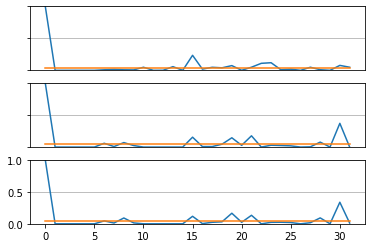

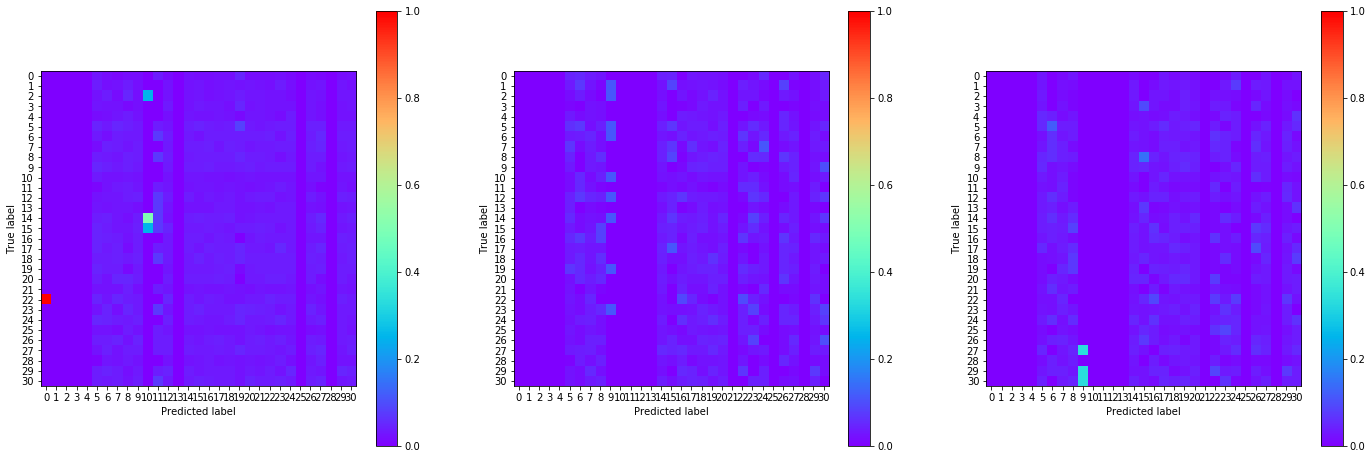

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
11:49:09.067214
#001 [Train: 3.288] [Test: 3.113] [Valid: 3.084]
#001 [Train: 0.075] [Test: 0.111] [Valid: 0.117]


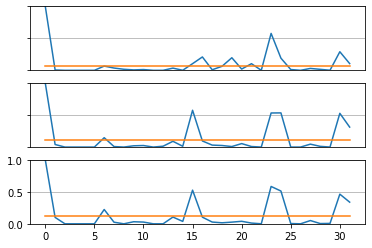

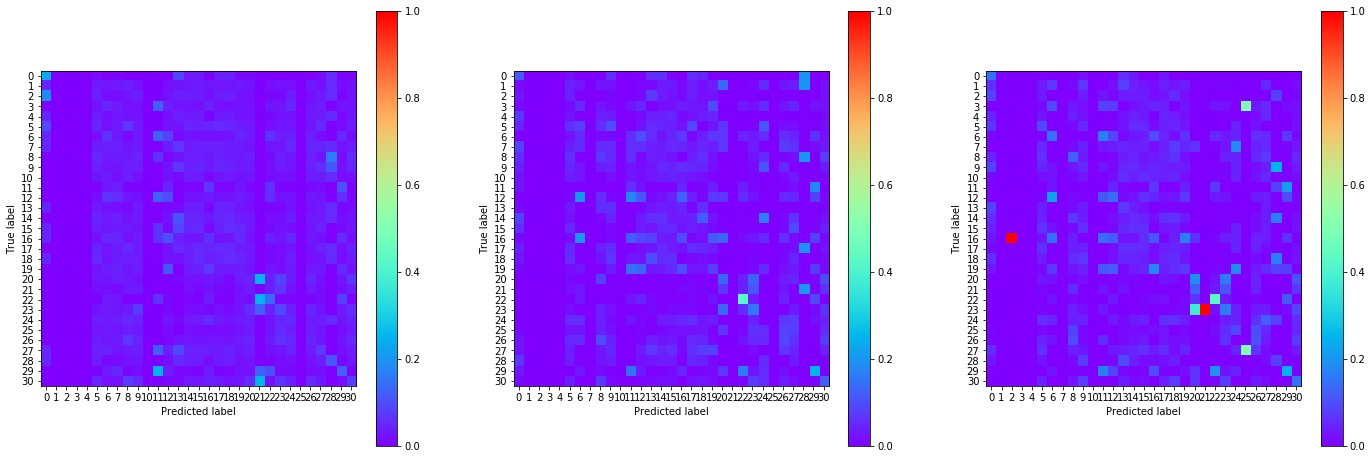

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
11:49:36.572562
#002 [Train: 2.971] [Test: 2.876] [Valid: 2.842]
#002 [Train: 0.122] [Test: 0.137] [Valid: 0.151]


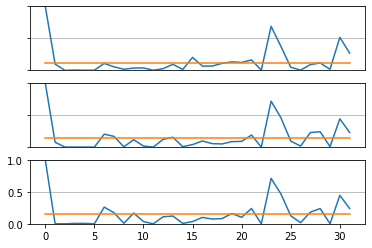

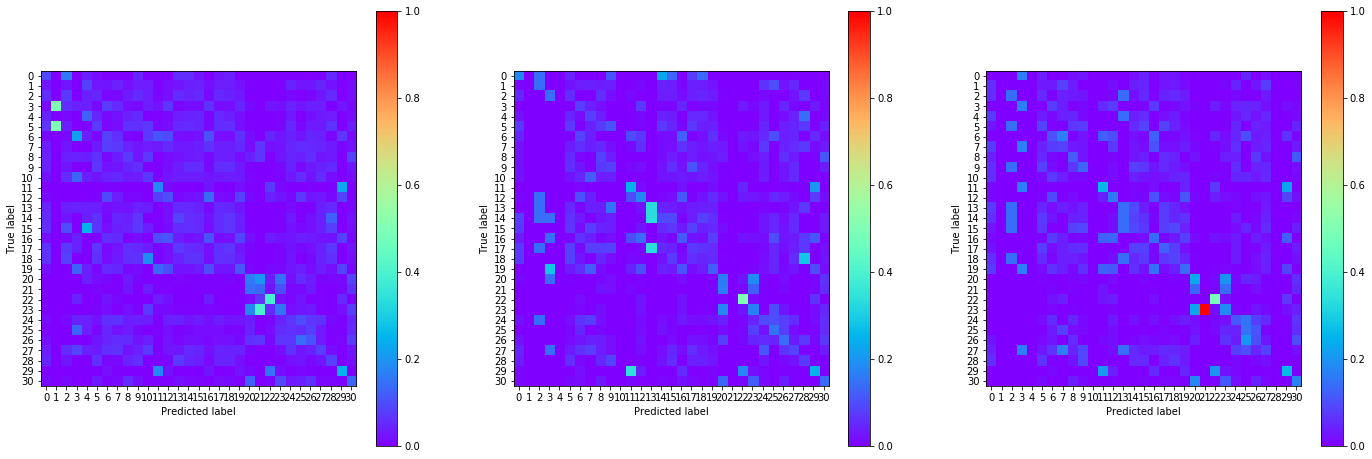

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
11:50:04.067794
#003 [Train: 2.800] [Test: 2.738] [Valid: 2.713]
#003 [Train: 0.155] [Test: 0.178] [Valid: 0.176]


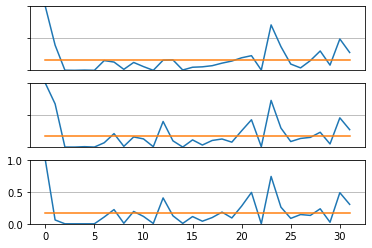

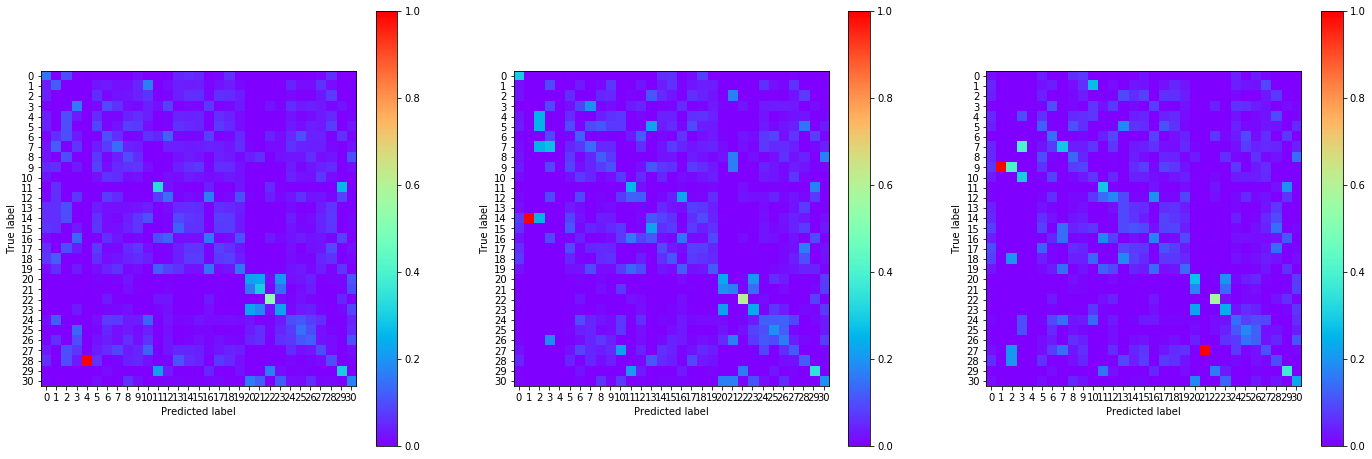

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
11:50:31.576199
#004 [Train: 2.649] [Test: 2.587] [Valid: 2.572]
#004 [Train: 0.194] [Test: 0.225] [Valid: 0.206]


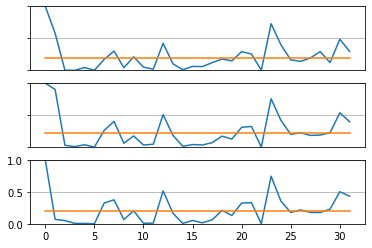

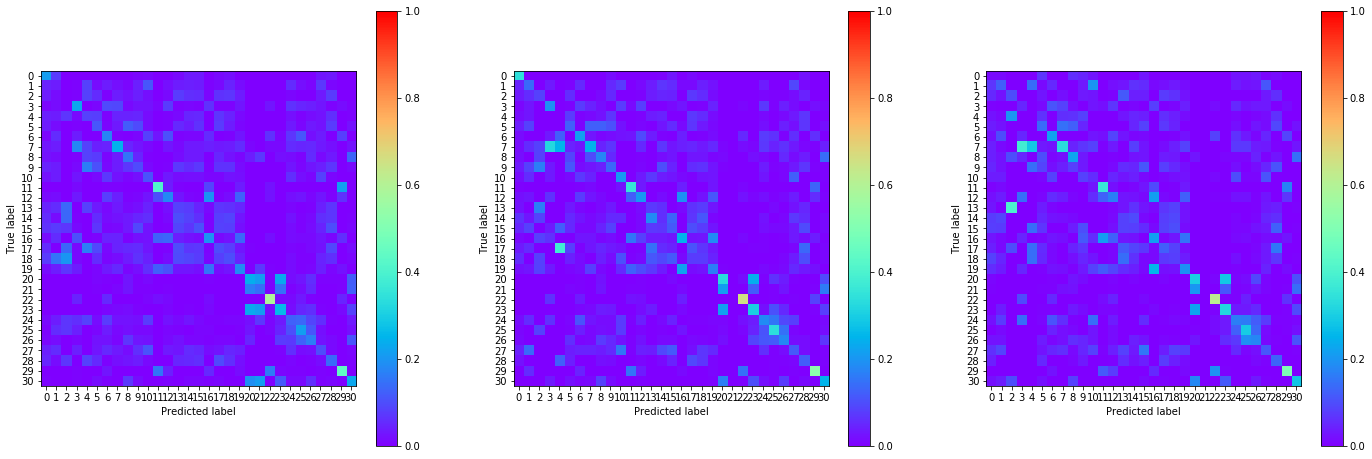

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
11:51:10.747221
#005 [Train: 2.498] [Test: 2.435] [Valid: 2.461]
#005 [Train: 0.235] [Test: 0.255] [Valid: 0.242]


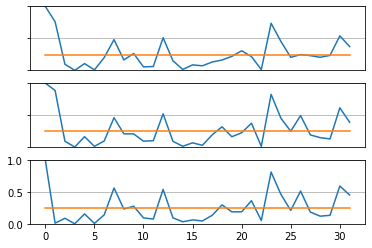

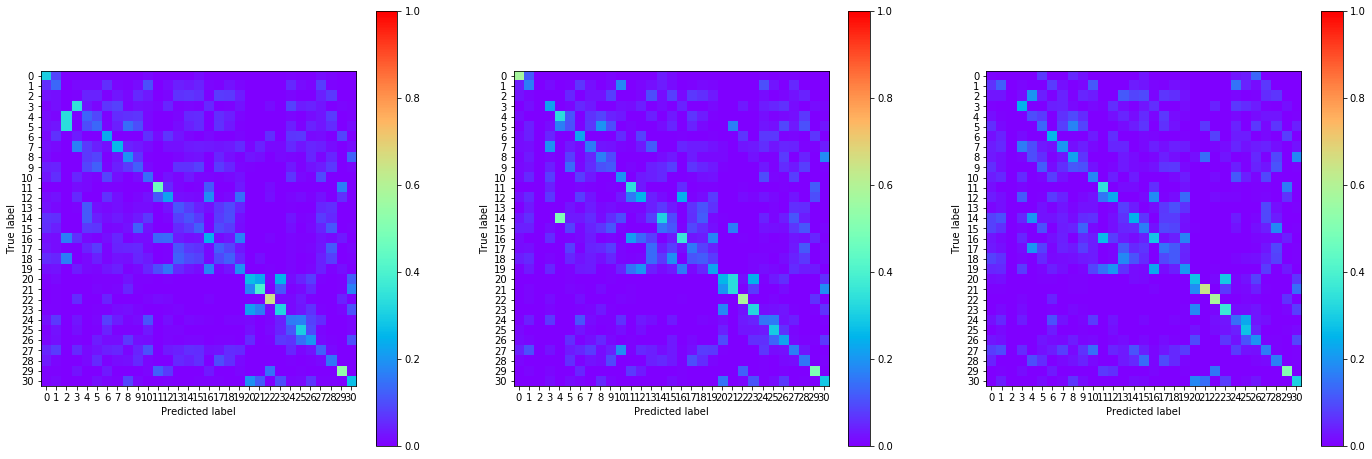

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
11:51:50.734658
#006 [Train: 2.326] [Test: 2.313] [Valid: 2.330]
#006 [Train: 0.283] [Test: 0.298] [Valid: 0.286]


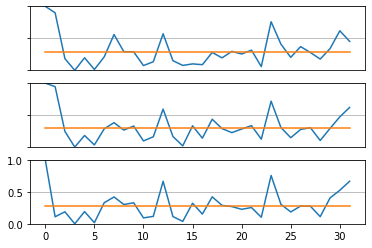

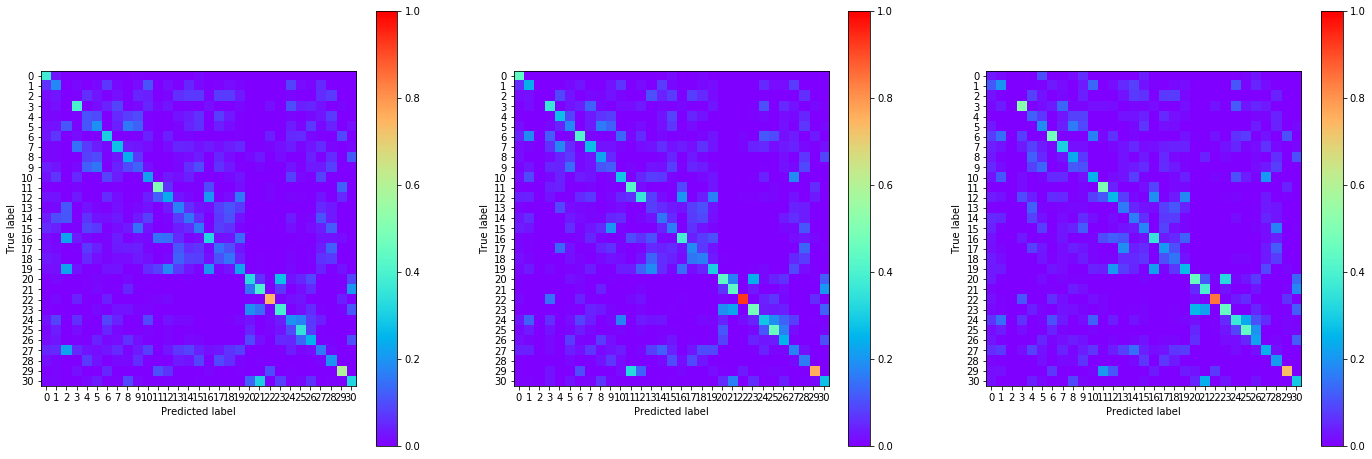

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
11:52:30.771741
#007 [Train: 2.155] [Test: 2.114] [Valid: 2.124]
#007 [Train: 0.334] [Test: 0.356] [Valid: 0.345]


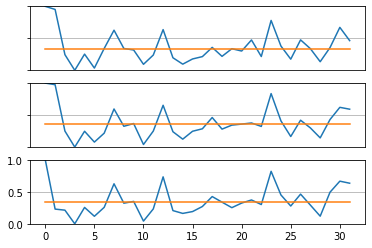

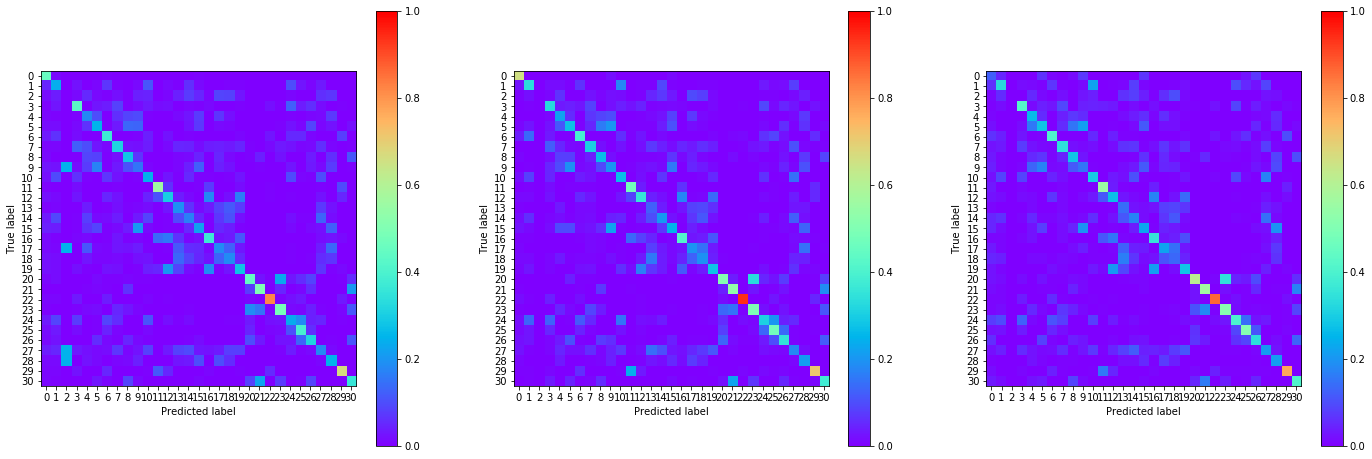

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
11:53:12.613008
#008 [Train: 1.987] [Test: 1.927] [Valid: 1.925]
#008 [Train: 0.390] [Test: 0.421] [Valid: 0.418]


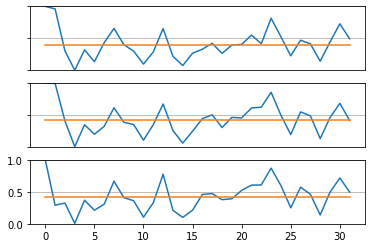

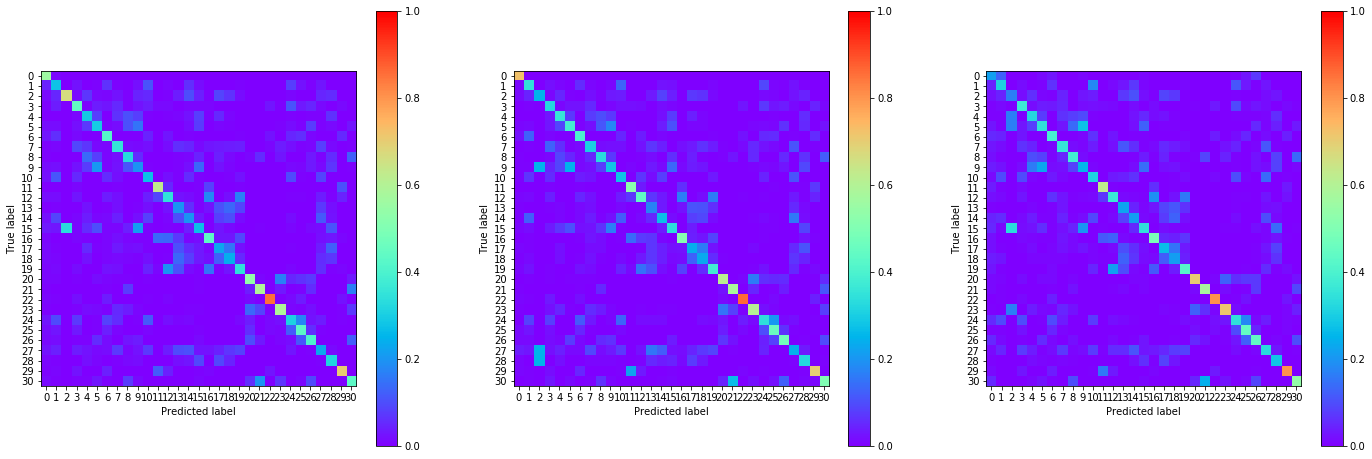

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
11:53:54.963411
#009 [Train: 1.827] [Test: 1.794] [Valid: 1.808]
#009 [Train: 0.442] [Test: 0.459] [Valid: 0.452]


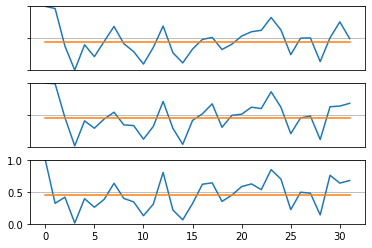

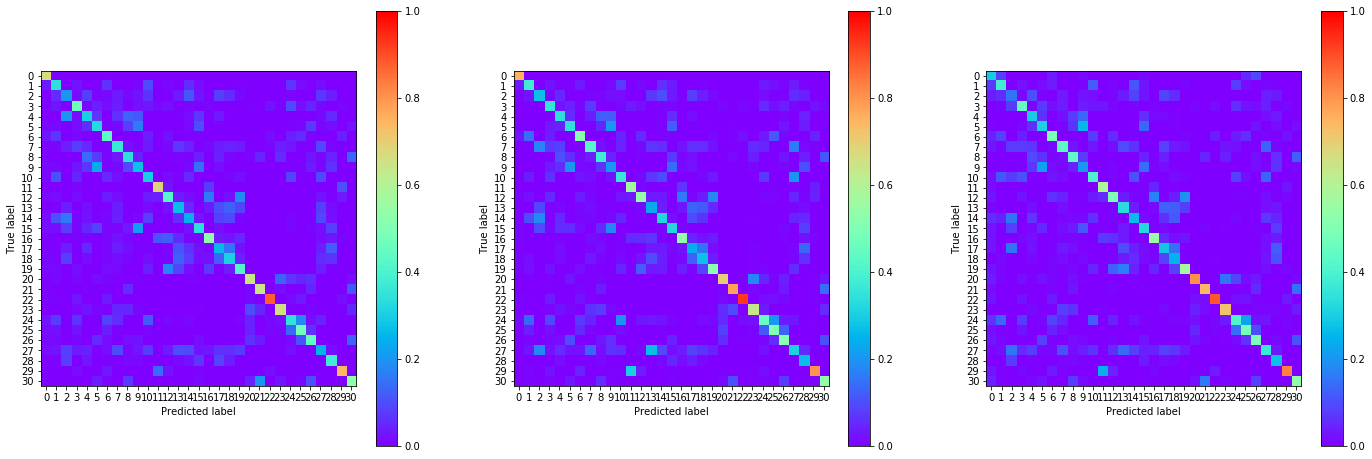

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
11:54:38.154831
#010 [Train: 1.691] [Test: 1.668] [Valid: 1.675]
#010 [Train: 0.483] [Test: 0.498] [Valid: 0.494]


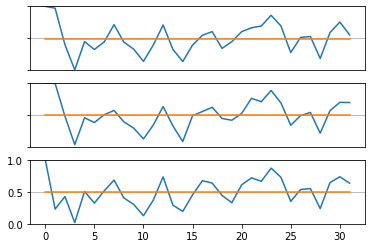

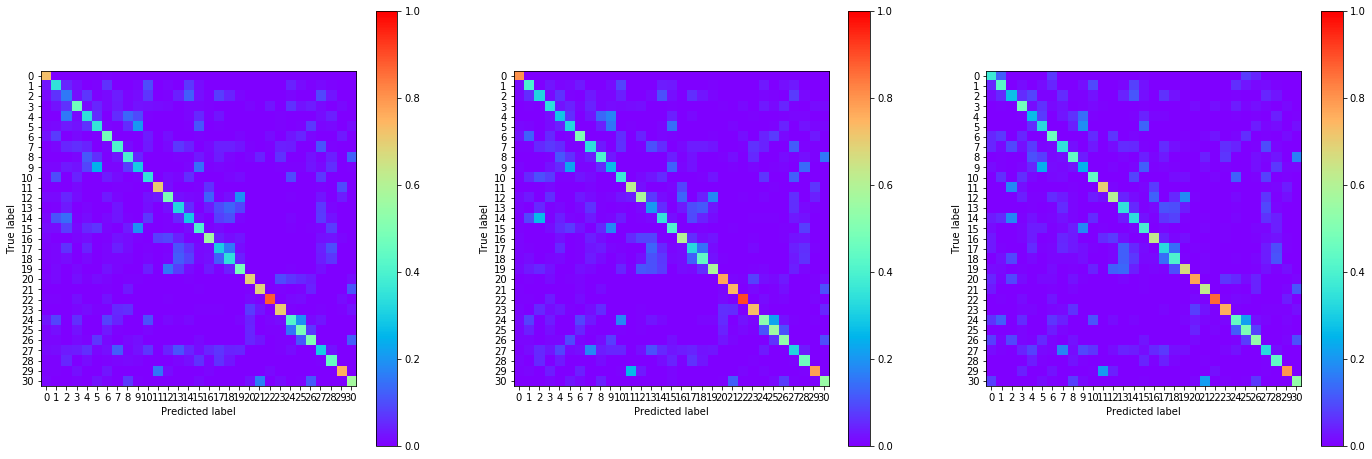

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
11:55:21.223665
#011 [Train: 1.569] [Test: 1.535] [Valid: 1.561]
#011 [Train: 0.521] [Test: 0.537] [Valid: 0.523]


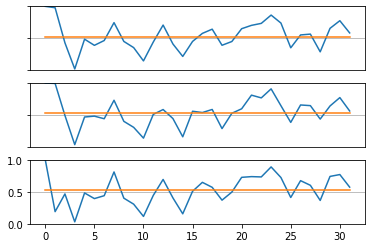

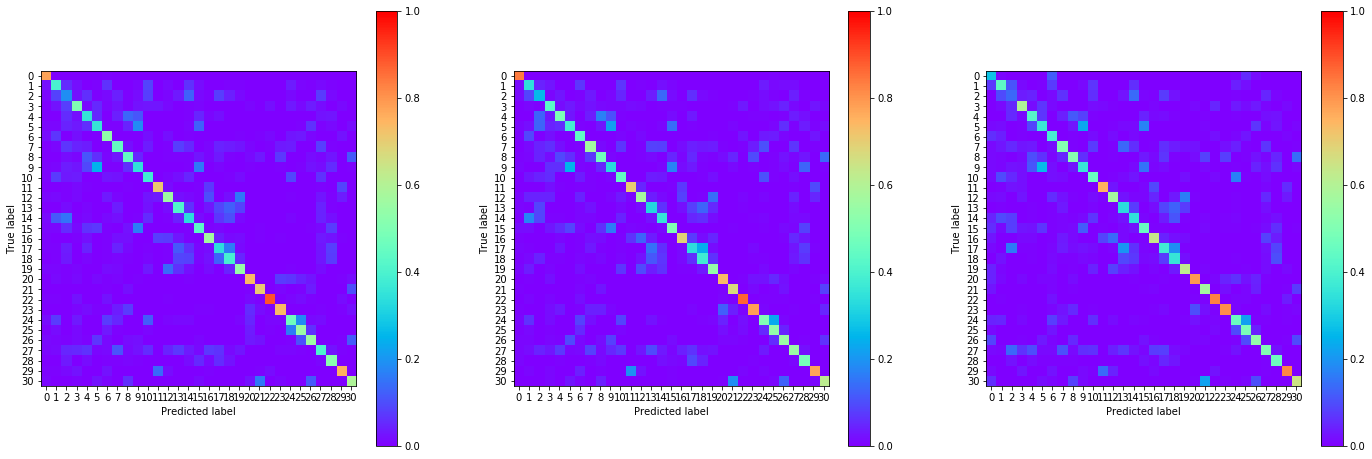

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
11:56:04.028015
#012 [Train: 1.451] [Test: 1.408] [Valid: 1.454]
#012 [Train: 0.560] [Test: 0.580] [Valid: 0.564]


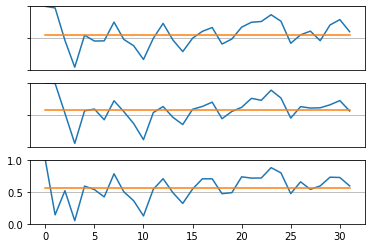

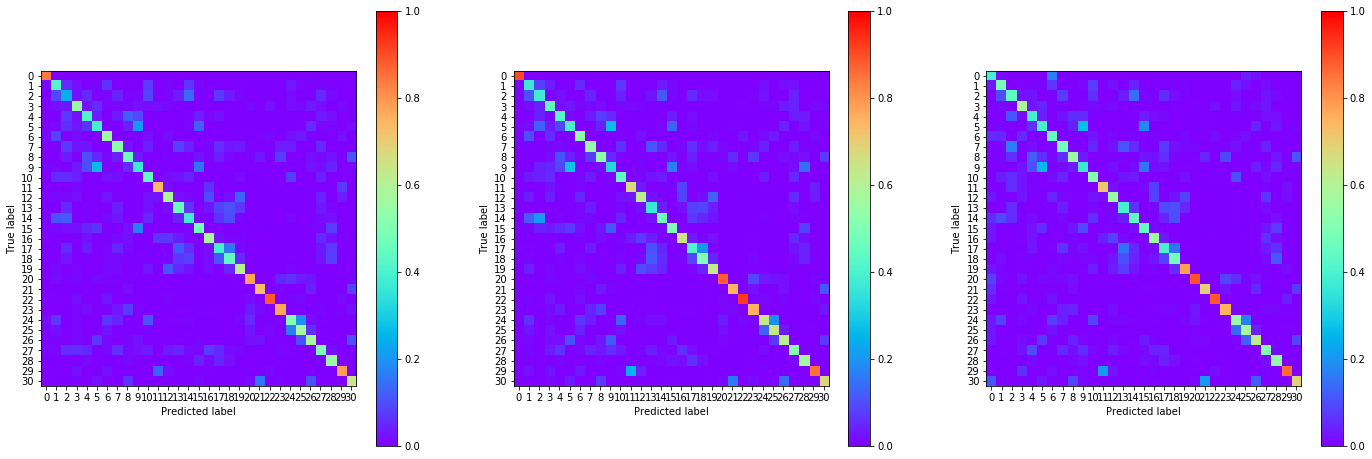

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
11:56:47.758154
#013 [Train: 1.350] [Test: 1.373] [Valid: 1.406]
#013 [Train: 0.592] [Test: 0.586] [Valid: 0.570]


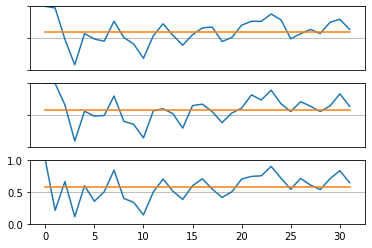

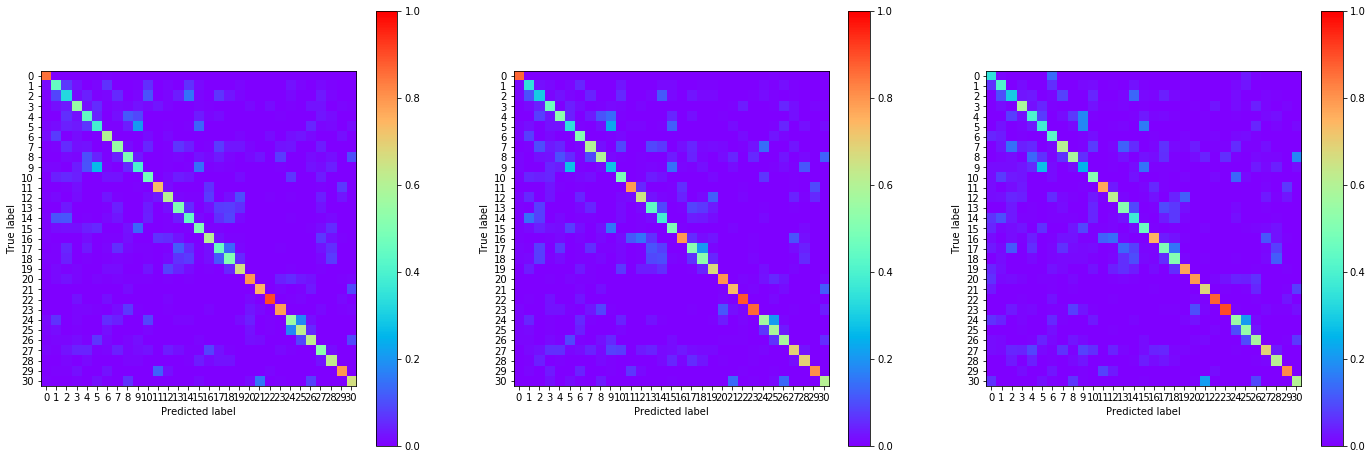

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
11:57:31.857012
#014 [Train: 1.250] [Test: 1.277] [Valid: 1.279]
#014 [Train: 0.624] [Test: 0.625] [Valid: 0.618]


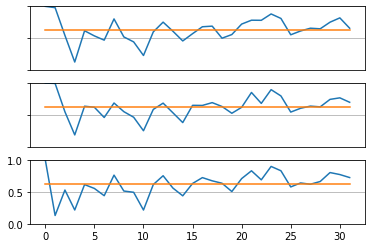

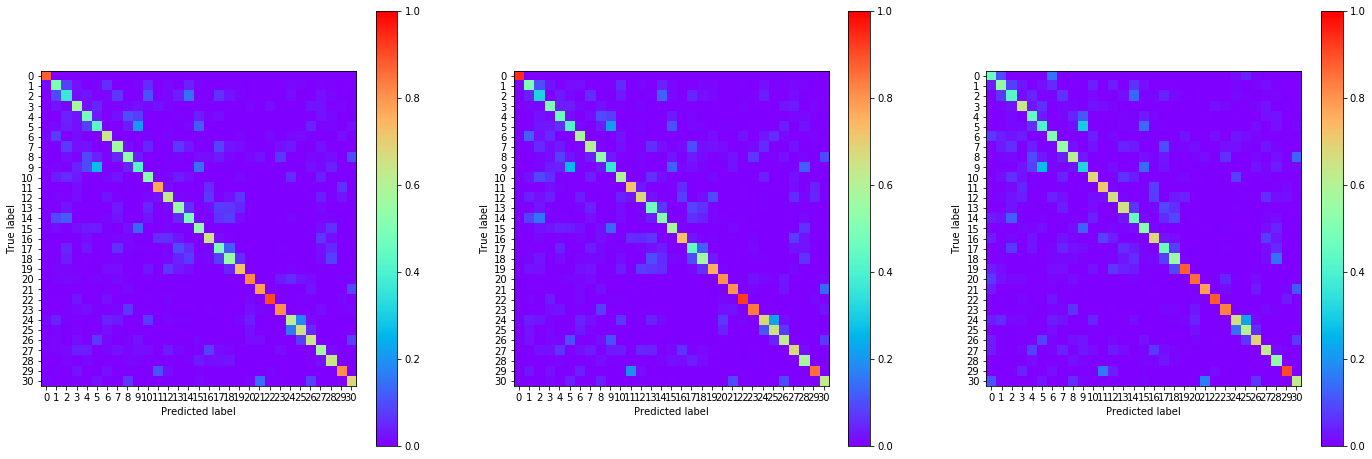

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
11:58:14.582229
#015 [Train: 1.168] [Test: 1.164] [Valid: 1.193]
#015 [Train: 0.648] [Test: 0.659] [Valid: 0.645]


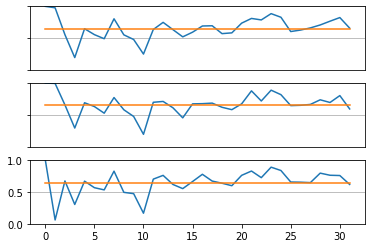

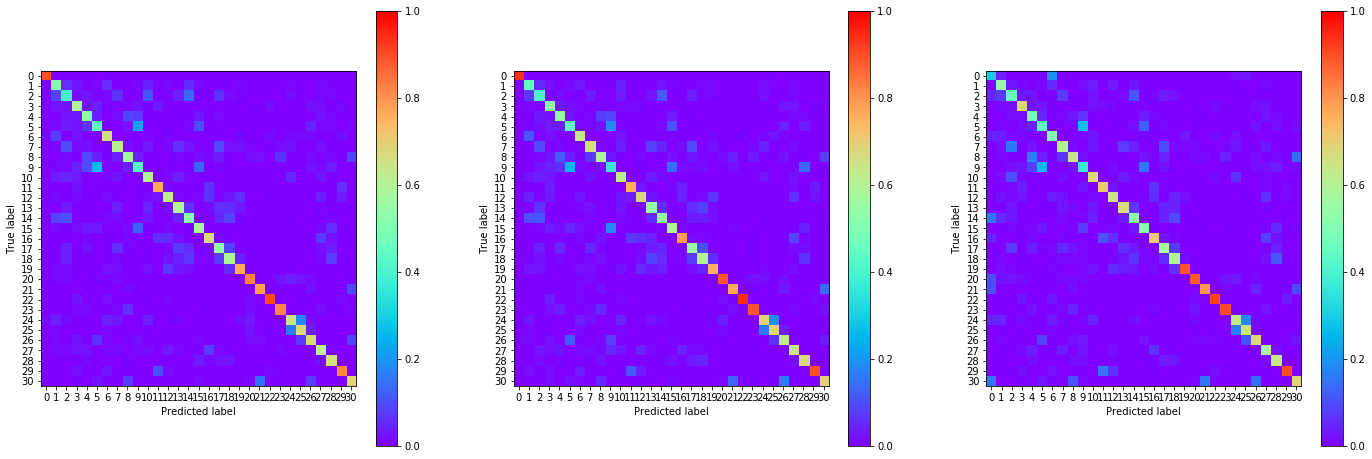

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
11:58:58.728424
#016 [Train: 1.086] [Test: 1.083] [Valid: 1.132]
#016 [Train: 0.673] [Test: 0.675] [Valid: 0.656]


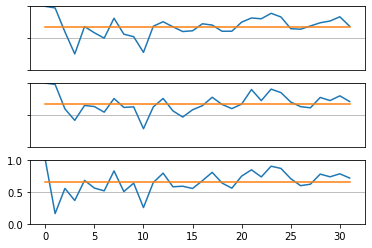

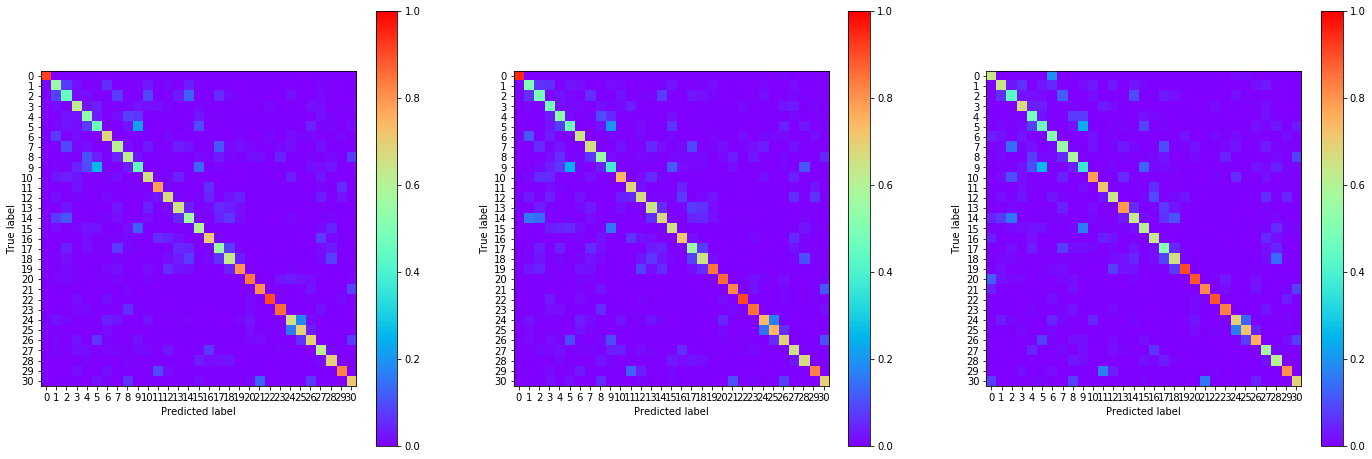

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
11:59:42.130752
#017 [Train: 1.018] [Test: 1.047] [Valid: 1.082]
#017 [Train: 0.694] [Test: 0.689] [Valid: 0.678]


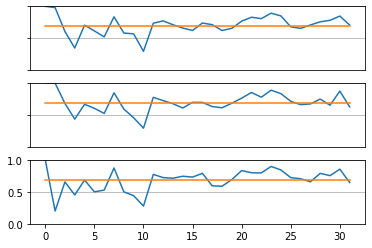

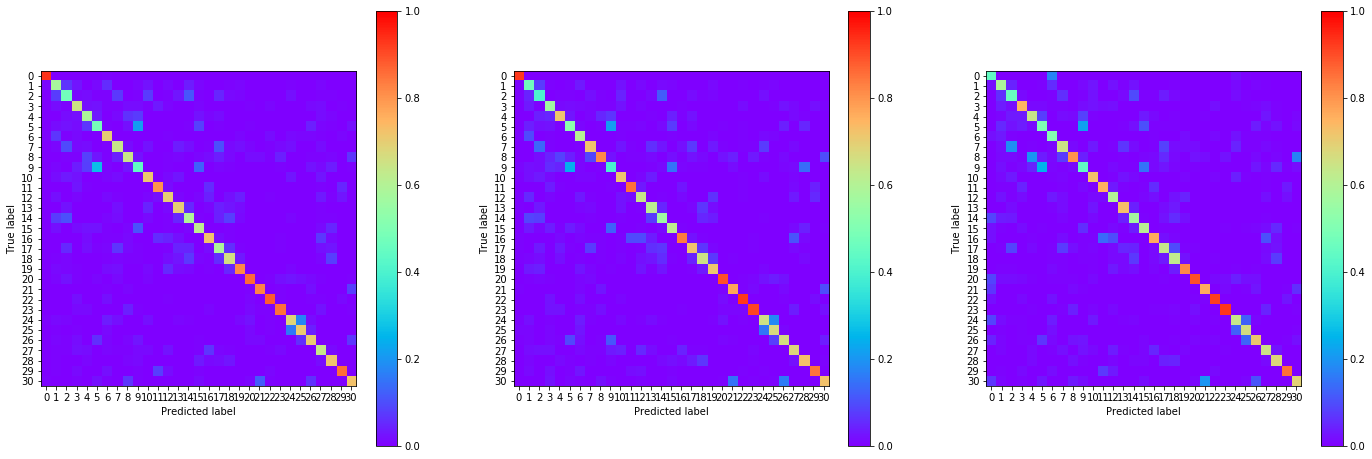

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
12:00:25.314719
#018 [Train: 0.968] [Test: 0.973] [Valid: 1.014]
#018 [Train: 0.709] [Test: 0.707] [Valid: 0.701]


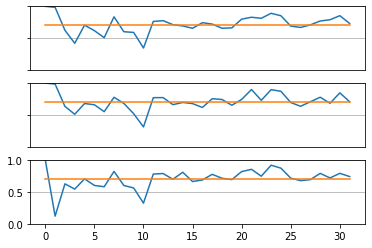

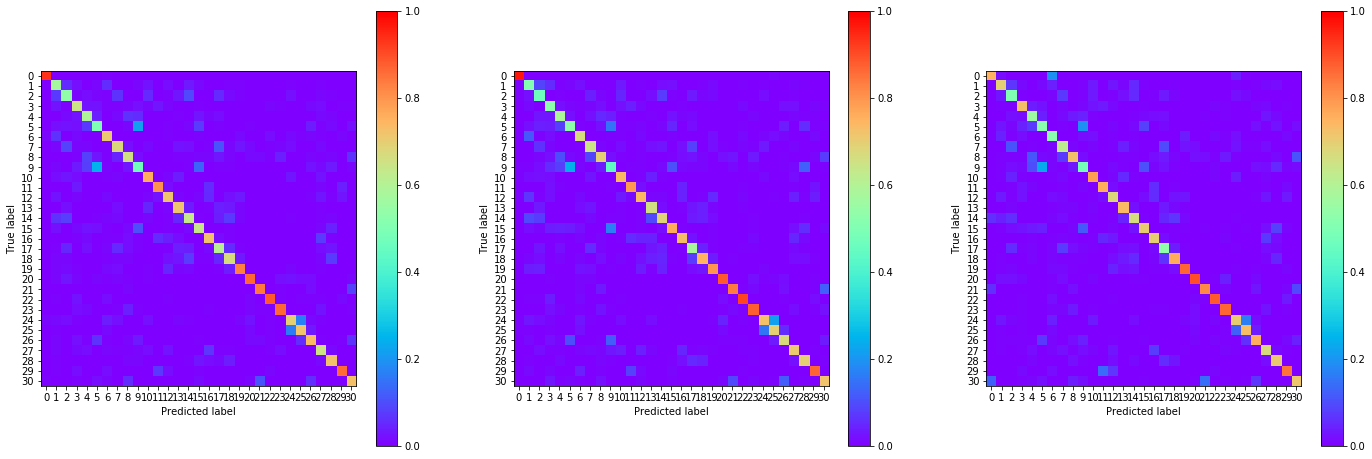

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
12:01:06.589080
#019 [Train: 0.904] [Test: 0.929] [Valid: 0.956]
#019 [Train: 0.729] [Test: 0.725] [Valid: 0.719]


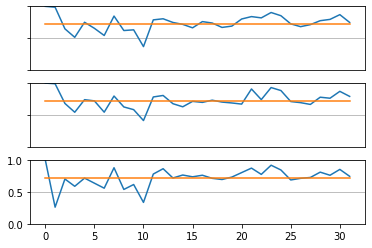

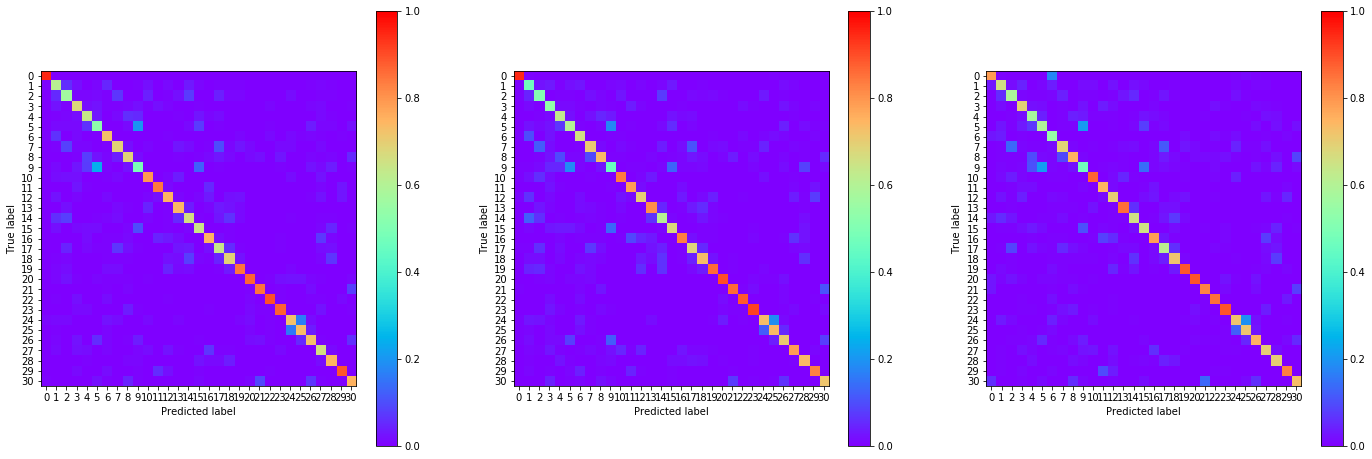

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
12:01:50.805808
#020 [Train: 0.856] [Test: 0.871] [Valid: 0.909]
#020 [Train: 0.743] [Test: 0.735] [Valid: 0.721]


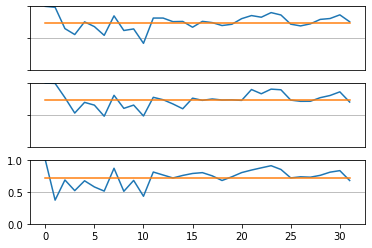

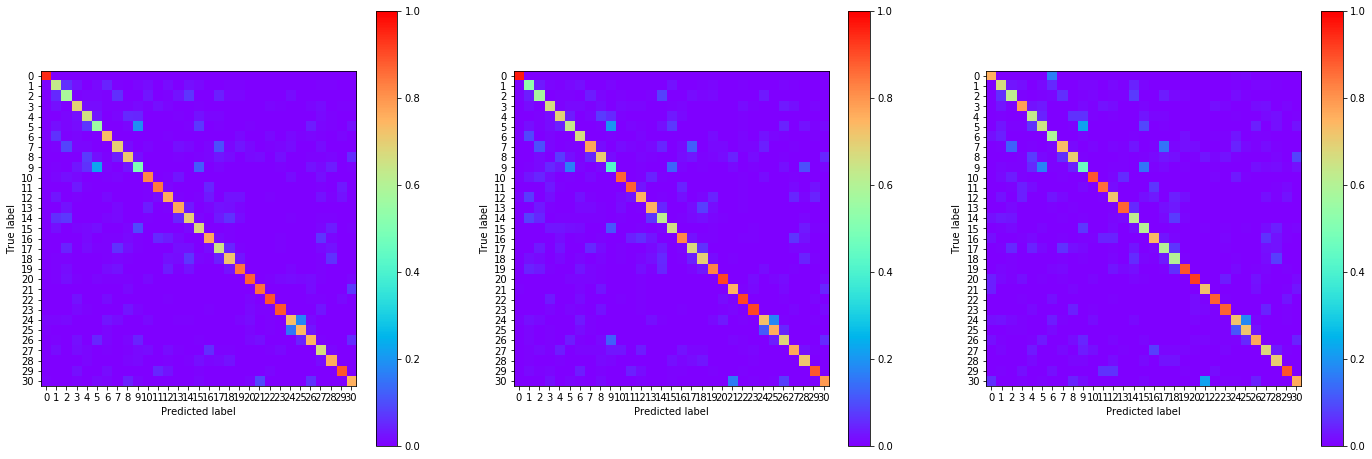

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
12:02:33.760269
#021 [Train: 0.811] [Test: 0.861] [Valid: 0.882]
#021 [Train: 0.759] [Test: 0.747] [Valid: 0.738]


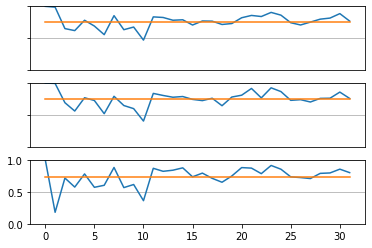

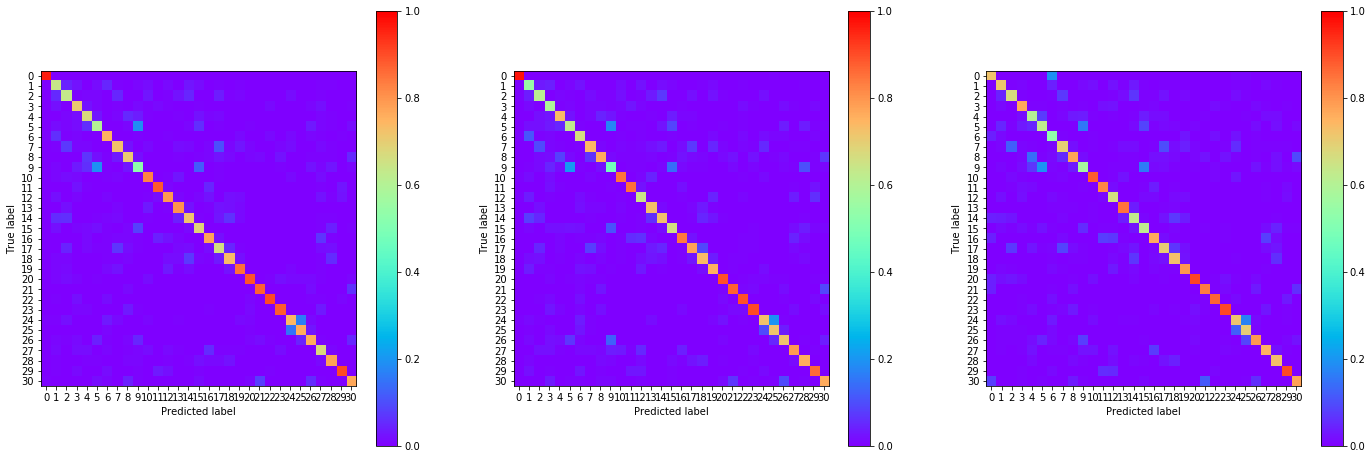

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
12:03:17.628331
#022 [Train: 0.776] [Test: 0.814] [Valid: 0.825]
#022 [Train: 0.768] [Test: 0.758] [Valid: 0.745]


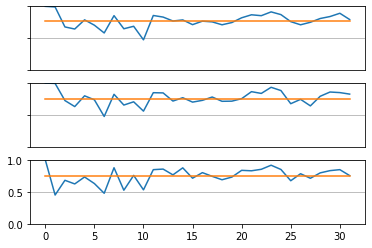

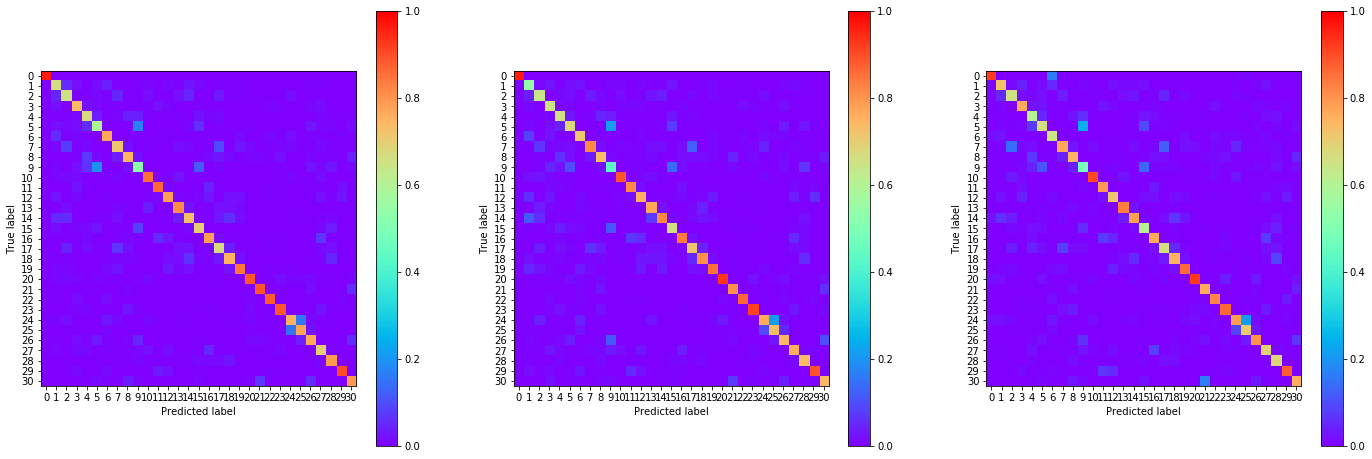

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
12:04:00.309037
#023 [Train: 0.734] [Test: 0.776] [Valid: 0.814]
#023 [Train: 0.783] [Test: 0.771] [Valid: 0.763]


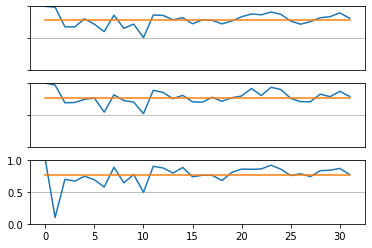

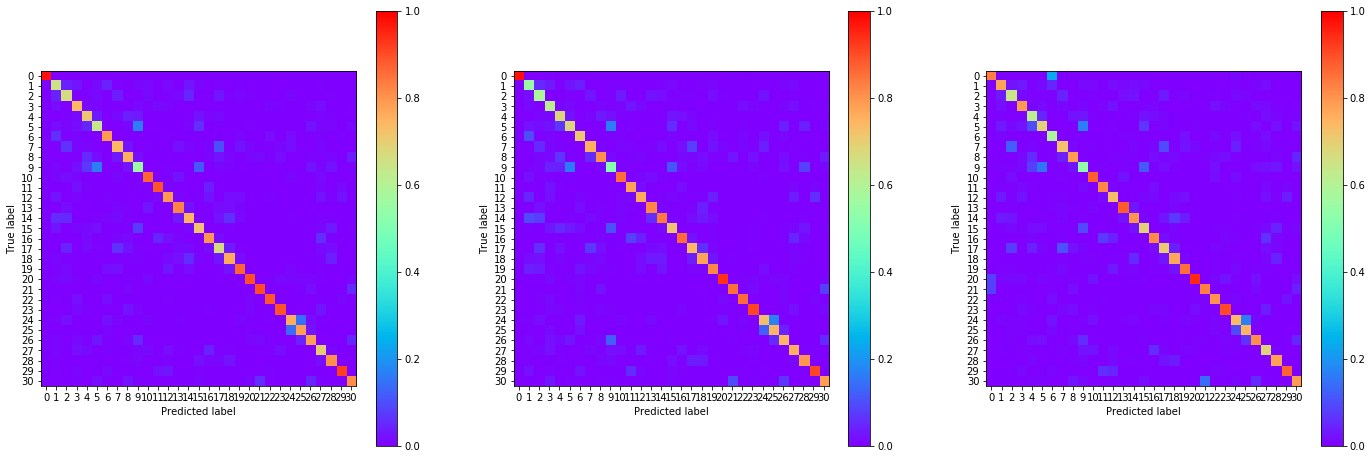

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]
12:04:44.435969
#024 [Train: 0.696] [Test: 0.744] [Valid: 0.774]
#024 [Train: 0.794] [Test: 0.779] [Valid: 0.767]


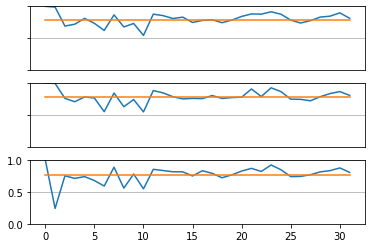

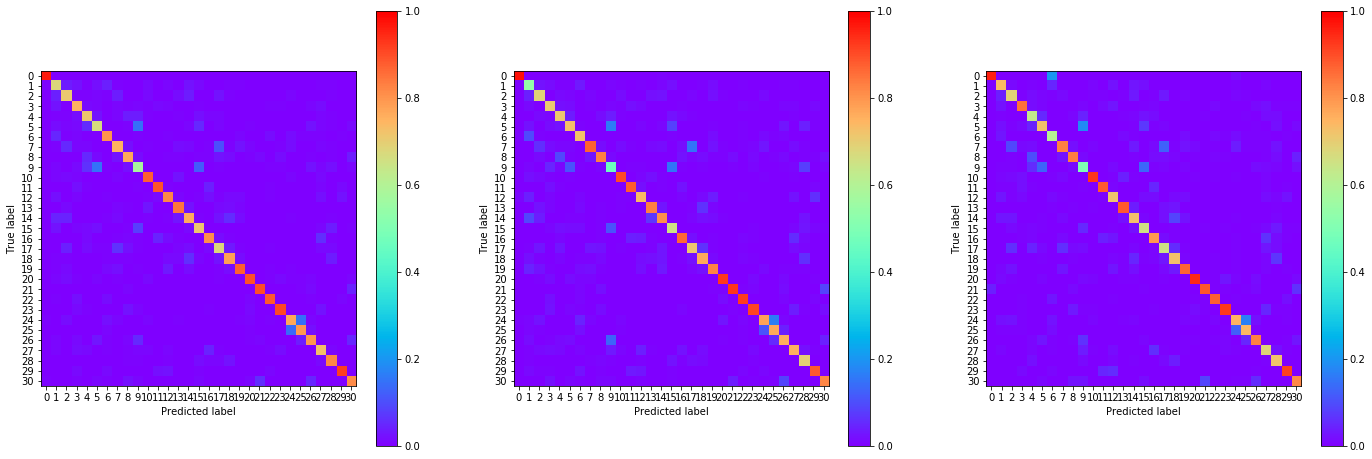

[Model Saved: models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt]


In [ ]:
MAX_EPOCH = 300

max_acc_valid = 0.0

writer = SummaryWriter(log_dir=run_name)

for epoch in range(MAX_EPOCH):
    training_loss_list = list()
    batch_generator = dataset_loader_training.batch_generator()
    model.train()
    
    correct_num = 0
    total_num = 0
    
#     result_matrix_train = np.zeros([31, 2])
    result_matrix_train = np.zeros([32, 2])
    result_matrix_train[0, :] = [1, 1]
    y_pred_train = list()
    y_true_train = list()

    for (batch, label) in batch_generator:
        optimizer.zero_grad()
        pred = model(torch.cuda.FloatTensor(batch))
        loss = F.nll_loss(pred, torch.cuda.LongTensor(label))
        loss.backward()
        training_loss_list.append(loss.item())
        optimizer.step()
        
        _, pred_label = torch.max(pred, 1)
        correct_num += int((pred_label == torch.cuda.LongTensor(label)).sum().cpu().numpy())
        total_num += len(label)
        
        prediction_result = (pred_label == torch.cuda.LongTensor(label)).cpu().numpy()
        prediction_table = sorted(list(zip(prediction_result, label)), key = lambda x: x[1])
        
        y_true_train += list(label)
        y_pred_train += list(pred_label.cpu().numpy())
        
        for result, label in prediction_table:
            result_matrix_train[label, 0] += 1
            if result:
                result_matrix_train[label, 1] += 1
        
    acc_train = correct_num / total_num

    testing_loss_list = list()

    batch_generator = dataset_loader_testing.batch_generator()

    model.eval()
    
    correct_num = 0
    total_num = 0
    
#   result_matrix_test = np.zeros([31, 2])
    result_matrix_test = np.zeros([32, 2])
    result_matrix_test[0, :] = [1, 1]
    y_pred_test = list()
    y_true_test = list()

    for (batch, label) in batch_generator:
    #     optimizer.zero_grad()
        pred = model(torch.cuda.FloatTensor(batch))
        loss = F.nll_loss(pred, torch.cuda.LongTensor(label).to(device))
#         loss.backward()
        testing_loss_list.append(loss.item())
    #     optimizer.step()
    
        _, pred_label = torch.max(pred, 1)
        correct_num += int((pred_label == torch.cuda.LongTensor(label)).sum().cpu().numpy())
        total_num += len(label)
        
        prediction_result = (pred_label == torch.cuda.LongTensor(label)).cpu().numpy()
        prediction_table = sorted(list(zip(prediction_result, label)), key = lambda x: x[1])
        
        y_true_test += list(label)
        y_pred_test += list(pred_label.cpu().numpy())
        
        for result, label in prediction_table:
            result_matrix_test[label, 0] += 1
            if result:
                result_matrix_test[label, 1] += 1
        
    acc_test = correct_num / total_num

    validation_loss_list = list()

    batch_generator = dataset_loader_validation.batch_generator()
    
    correct_num = 0
    total_num = 0
    
#     result_matrix_eval = np.zeros([31, 2])
    result_matrix_eval = np.zeros([32, 2])
    result_matrix_eval[0, :] = [1, 1]
    y_pred_eval = list()
    y_true_eval = list()

    for (batch, label) in batch_generator:
    #     optimizer.zero_grad()
        pred = model(torch.cuda.FloatTensor(batch))
        loss = F.nll_loss(pred, torch.cuda.LongTensor(label))
#         loss.backward()
        validation_loss_list.append(loss.item())
    #     optimizer.step()
    
        _, pred_label = torch.max(pred, 1)
        correct_num += int((pred_label == torch.cuda.LongTensor(label)).sum().cpu().numpy())
        total_num += len(label)
        
        prediction_result = (pred_label == torch.cuda.LongTensor(label)).cpu().numpy()
        prediction_table = sorted(list(zip(prediction_result, label)), key = lambda x: x[1])
        
        y_true_eval += list(label)
        y_pred_eval += list(pred_label.cpu().numpy())
        
        for result, label in prediction_table:
            result_matrix_eval[label, 0] += 1
            if result:
                result_matrix_eval[label, 1] += 1
        
    acc_valid = correct_num / total_num
    
    training_loss_mean = np.mean(training_loss_list)
    testing_loss_mean = np.mean(testing_loss_list)
    validation_loss_mean = np.mean(validation_loss_list)
    
    print(datetime.datetime.now().time())
    print('#{:03d} [Train: {:0.3f}] [Test: {:0.3f}] [Valid: {:0.3f}]'.format(epoch, training_loss_mean, testing_loss_mean, validation_loss_mean))
    print('#{:03d} [Train: {:0.3f}] [Test: {:0.3f}] [Valid: {:0.3f}]'.format(epoch, acc_train, acc_test, acc_valid))
    
#     print(result_matrix_train)
#     print(result_matrix_test)
#     print(result_matrix_eval)
    
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)
    axes[0].plot(result_matrix_train[:, 1] / result_matrix_train[:, 0])
    axes[0].plot(np.ones(len(result_matrix_train)) * acc_train)
    axes[0].tick_params(bottom=False, top=False, labelbottom=False, right=False, labelleft=False)
    axes[0].set_ylim([0, 1])
    axes[0].yaxis.grid(True)
                 
    axes[1].plot(result_matrix_test[:, 1] / result_matrix_test[:, 0])
    axes[1].plot(np.ones(len(result_matrix_test)) * acc_test)
    axes[1].tick_params(bottom=False, top=False, labelbottom=False, right=False, labelleft=False)
    axes[1].set_ylim([0, 1])
    axes[1].yaxis.grid(True)
                 
    axes[2].plot(result_matrix_eval[:, 1] / result_matrix_eval[:, 0])
    axes[2].plot(np.ones(len(result_matrix_eval)) * acc_valid)
    axes[2].set_ylim([0, 1])
    axes[2].yaxis.grid(True)
    plt.show()
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
    cm = confusion_matrix(y_true_train, y_pred_train, normalize='pred')
#     axes[0].imshow(cm)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(32))
    disp.plot(include_values=False, ax=axes[0], xticks_rotation='horizontal', cmap='rainbow')
    for im in axes[0].get_images():
        im.set_clim(0, 1)
    
    cm = confusion_matrix(y_true_test, y_pred_test, normalize='pred')
#     axes[1].imshow(cm)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(32))
    disp.plot(include_values=False, ax=axes[1], xticks_rotation='horizontal', cmap='rainbow')
    for im in axes[1].get_images():
        im.set_clim(0, 1)
    
    cm = confusion_matrix(y_true_eval, y_pred_eval, normalize='pred')
#     im = axes[2].imshow(cm)
#     plt.colorbar(im)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(32))
    disp.plot(include_values=False, ax=axes[2], xticks_rotation='horizontal', cmap='rainbow')
    for im in axes[2].get_images():
        im.set_clim(0, 1)
    
    plt.show()
    
    writer.add_scalar('Loss/Train', training_loss_mean, epoch)
    writer.add_scalar('Loss/Test', testing_loss_mean, epoch)
    writer.add_scalar('Loss/Valid', validation_loss_mean, epoch)
    writer.add_scalar('Acc/Train', acc_train, epoch)
    writer.add_scalar('Acc/Test', acc_test, epoch)
    writer.add_scalar('Acc/Valid', acc_valid, epoch)
    
    if acc_valid > max_acc_valid:
        max_acc_valid = acc_valid
        torch.save(model.state_dict(), model_save_path)
        print('[Model Saved: {}]'.format(model_save_path))
    

In [ ]:
# output = model(torch.cuda.FloatTensor(batch))

In [ ]:
# output.shape

In [ ]:
# torch.tensor(batch).unsqueeze_(1).shape

In [ ]:
# input_tensor = torch.tensor(batch).to(device).float()
# input_tensor = input_tensor.transpose(1, 2)
# model(input_tensor).shape

In [ ]:
# for batch, label_list in batch_generator:
#     print(batch.shape[0])
#     plt.figure(figsize=(5, 1))
#     plt.plot(label_list)
#     plt.show()
    
#     plt.figure(figsize=(6, 18))
# #     plt.imshow(batch[0], aspect='auto')
#     plt.imshow(batch[0])
#     plt.show()
    
#     break